# Permutation test

1. Compute the empirical mean for each group
2. Calculate difference of means ($\Delta \mu = \mu_F - \mu_M$)
3. Permutate labels randomly with same ratio of females and males
4. Compute sample mean for current permutation
5. Calculate difference of means for current permutation ($\Delta \bar{X} = \bar{X}_F - \bar{X}_M$)
6. Repeat step 3-5 $N$ times

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

In [2]:
researchers = pd.read_pickle("Files/Dataframes/researchers.pkl") 

In [3]:
#divide data into their session type
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee']

#divide data into gender
males = researchers[researchers.Gender == 'Male']
females = researchers[researchers.Gender == 'Female']

## Functions

In [4]:
def permutationTest(df, labelColumn, labelVals, attributes, iterations): #
    meanDiff = {}
    permutationDict = {key: [] for key in attributes}
    dict0 = {key: [] for key in attributes} #dict for first labelVal
    dict1 = {key: [] for key in attributes} #dict for second labelVal
    table = df.groupby(labelColumn).mean(numeric_only = True)[attributes]
    
    for c in attributes:
        meanDiff[c + "_meanDiff"] = table[c][labelVals[0]] - table[c][labelVals[1]]
    for i in range(0,iterations):
        permutation = np.random.permutation(df[labelColumn].values)
        df[labelColumn + 'Permutation'] = permutation
        table_permutation = df.groupby(labelColumn + 'Permutation').mean(numeric_only = True)[attributes]
        for c in attributes:
            permutation0 = table_permutation[c][labelVals[0]] 
            permutation1 = table_permutation[c][labelVals[1]]

            permutationDiff = permutation0 - permutation1
            permutationDict[c].append(permutationDiff)

    return meanDiff, permutationDict

In [5]:
def getP_value(permutation_df, attributes, deltas):
    p_values = {}
    p_values_abs = {}
    n = len(permutation_df)
    for c in attributes:
        p_values[c] = len(permutation_df[permutation_df[c] < deltas[c + "_meanDiff"]])/n
    return p_values

In [6]:
def yearlyPermutationTest(df, labelColumn, labelVals, attributes, iterations):
    delta_yearly = {}
    permutationDelta_yearly = {}
    yearList = df.Year.unique()
    for y in yearList:
        df_yearly = df[df.Year == y]
        delta_yearly[y], permutationDelta_yearly[y] = permutationTest(df_yearly, labelColumn, labelVals, attributes, iterations)

    return delta_yearly, permutationDelta_yearly

In [7]:
def yearlyP_value(permutation_df, attributes, yearlyDelta):
    pValueDict = {}
    abs_pValueDict = {}
    yearList = permutation_df.Year.unique()
    for y in yearList:
        df_yearlyPermutation = permutation_df[permutation_df.Year == y]
        pValueDict[y] = getP_value(permutation_df, attributes, yearlyDelta[y])
    
    return pValueDict

In [8]:
def getDiff(df, labelColumn, attributes): #get difference between mean of labelColumn for each year for each stated attribute
    diffDict = {}
    index = 0
    table = df.groupby(['Year', labelColumn]).mean(numeric_only = True)
    years = df.Year.unique()
    for y in years:
        for c in attributes:
            maleValues = table[c][[(y, 'Male')]].iloc[0]
            femaleValues = table[c][[(y, 'Female')]].iloc[0]
            diff = femaleValues - maleValues
            diffDict[index] = {'Year': y, 'Attribute': c, 'Difference': diff}
            index += 1
    return diffDict

H0: $X_F = X_M$
- P-value: fraction of random differences smaller than real difference
- P-value > $\alpha$: real difference is larger than expected by chance. Can't reject that female > male
- P-value < $\alpha$: real difference is smaller than expected by chance. Can't reject that female < male

## Permutation test 

### Gender

In [9]:
#delta, permutationMales, permutationFemales, permutationDelta = permutationTest(invited, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
delta_inv, permutationDelta_inv = permutationTest(invited, 'Gender', ['Female', 'Male'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
delta_att, permutationDelta_att = permutationTest(attendees, 'Gender', ['Female', 'Male'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [10]:
#convert permutationDelta to df
permutation_df_inv = pd.DataFrame.from_dict(permutationDelta_inv)
permutation_df_att = pd.DataFrame.from_dict(permutationDelta_att)

In [11]:
#get p-values
p_values_inv = getP_value(permutation_df_inv, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_inv)
p_values_att = getP_value(permutation_df_att, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_att)

In [12]:
print("P-values from permutation test for invited speakers:", p_values_inv)
print("P-values from permutation test for attendees:", p_values_att)

P-values from permutation test for invited speakers: {'Seniority': 0.0, 'CumulativePaperCount': 0.0, 'Productivity': 0.0004}
P-values from permutation test for attendees: {'Seniority': 0.0, 'CumulativePaperCount': 0.0, 'Productivity': 0.0}


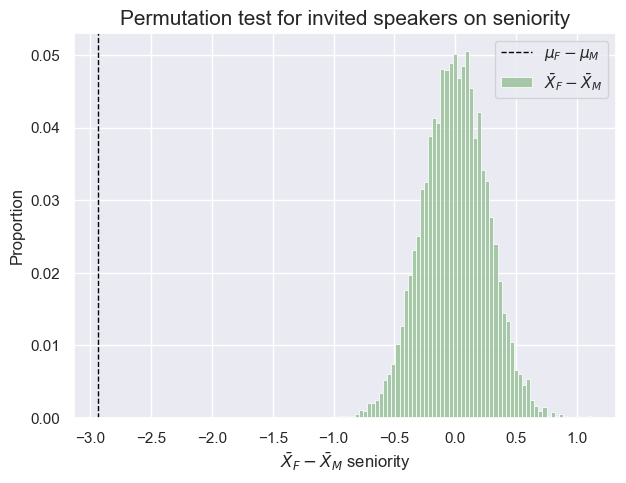

In [13]:
sns.histplot(data = permutation_df_inv, x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x = delta_inv['Seniority_meanDiff'], color = 'black', label = '$\mu_F - \mu_M$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ seniority', fontsize=12)
plt.title("Permutation test for invited speakers on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniorityInv", bbox_inches='tight')
plt.show()

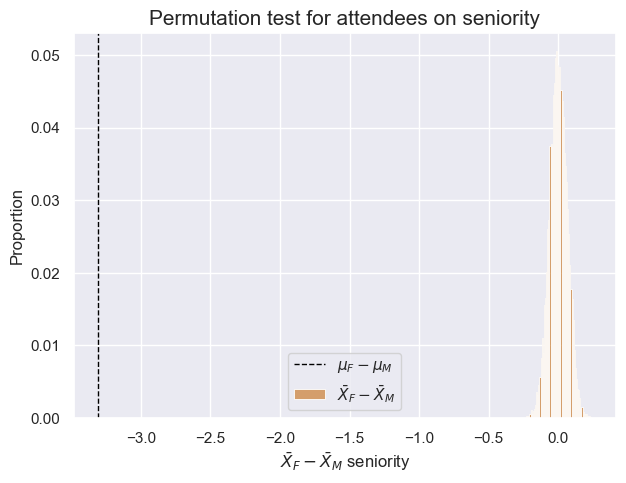

In [14]:
sns.histplot(data = permutation_df_att, x = 'Seniority', stat = 'proportion', color = 'peru', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x = delta_att['Seniority_meanDiff'], color = 'black', label = '$\mu_F - \mu_M$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ seniority', fontsize=12)
plt.title("Permutation test for attendees on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniorityAtt", bbox_inches='tight')
plt.show()

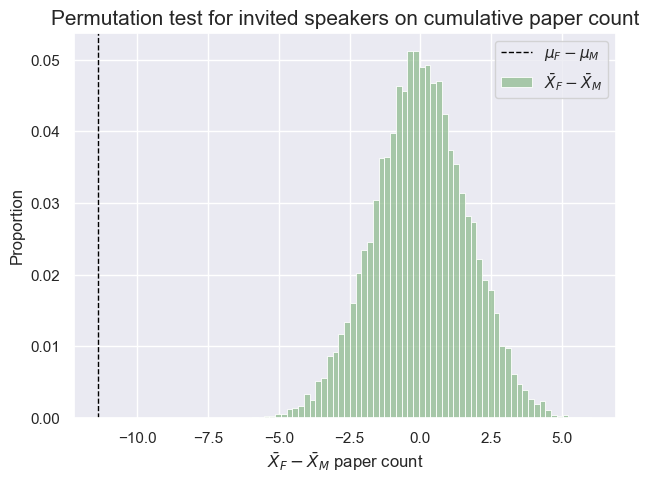

In [15]:
sns.histplot(data = permutation_df_inv, x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x=delta_inv['CumulativePaperCount_meanDiff'], color = 'black', linewidth = 1, label = '$\mu_F - \mu_M$').set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ paper count', fontsize=12)
plt.title("Permutation test for invited speakers on cumulative paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount_inv", bbox_inches='tight')
plt.show()

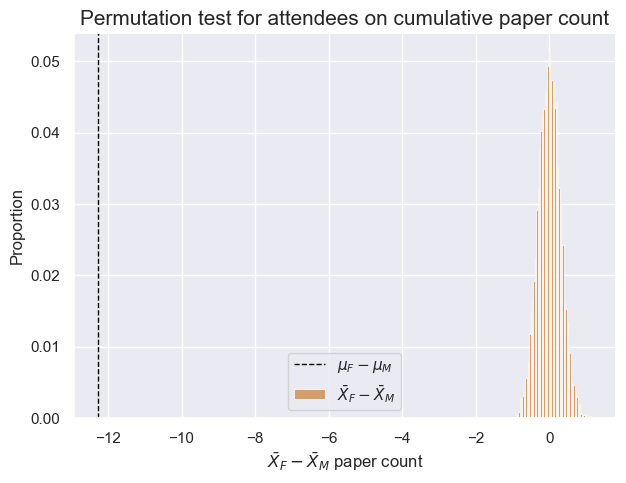

In [16]:
sns.histplot(data = permutation_df_att, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x=delta_att['CumulativePaperCount_meanDiff'], color = 'black', linewidth = 1, label = '$\mu_F - \mu_M$').set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ paper count', fontsize=12)
plt.title("Permutation test for attendees on cumulative paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount_att", bbox_inches='tight')
plt.show()

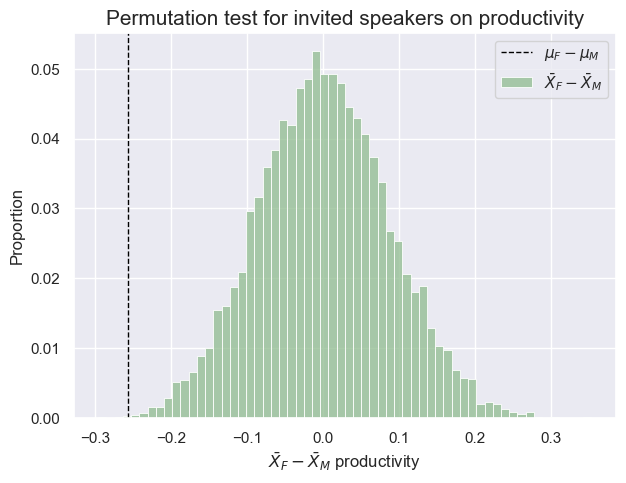

In [17]:
sns.histplot(data = permutation_df_inv, x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x=delta_inv['Productivity_meanDiff'], color = 'black', linewidth=1, label = '$\mu_F - \mu_M$').set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ productivity', fontsize=12)
plt.title("Permutation test for invited speakers on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity", bbox_inches='tight')
plt.show()

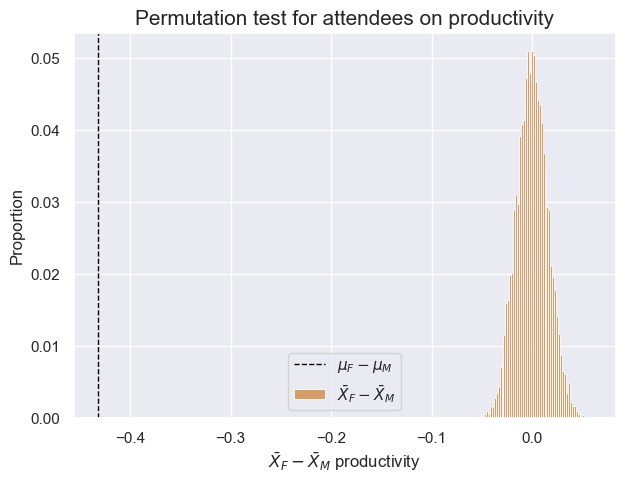

In [18]:
sns.histplot(data = permutation_df_att, x = 'Productivity', stat = 'proportion', color = 'peru', label = '$\\bar{X}_F - \\bar{X}_M$')
plt.axvline(x=delta_att['Productivity_meanDiff'], color = 'black', linewidth=1, label = '$\mu_F - \mu_M$').set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_F - \\bar{X}_M$ productivity', fontsize=12)
plt.title("Permutation test for attendees on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity_att", bbox_inches='tight')
plt.show()

### Session type

In [19]:
#do permutation test for session type(all and male and females seperately)
delta_sessionType, permutationDelta_sessType =  permutationTest(researchers, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
deltaM, permutationDelta_M = permutationTest(males, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
deltaF, permutationDelta_F = permutationTest(females, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [20]:
#convert permutationDelta to df
permutation_sessType = pd.DataFrame.from_dict(permutationDelta_sessType)
permutation_M = pd.DataFrame.from_dict(permutationDelta_M)
permutation_F = pd.DataFrame.from_dict(permutationDelta_F)

In [21]:
#get p-values
p_values_sessType = getP_value(permutation_sessType, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_sessionType)
p_values_M = getP_value(permutation_M, ['Seniority', 'CumulativePaperCount', 'Productivity'], deltaM)
p_values_F = getP_value(permutation_F, ['Seniority', 'CumulativePaperCount', 'Productivity'], deltaF)

In [22]:
print("P-values from permutation test with session type for all researchere:", p_values_sessType)
print("P-values from permutation test with session type for males:", p_values_M)
print("P-values from permutation test with session type for females:", p_values_F)

P-values from permutation test with session type for all researchere: {'Seniority': 1.0, 'CumulativePaperCount': 1.0, 'Productivity': 1.0}
P-values from permutation test with session type for males: {'Seniority': 1.0, 'CumulativePaperCount': 1.0, 'Productivity': 1.0}
P-values from permutation test with session type for females: {'Seniority': 1.0, 'CumulativePaperCount': 1.0, 'Productivity': 1.0}


### All researchers

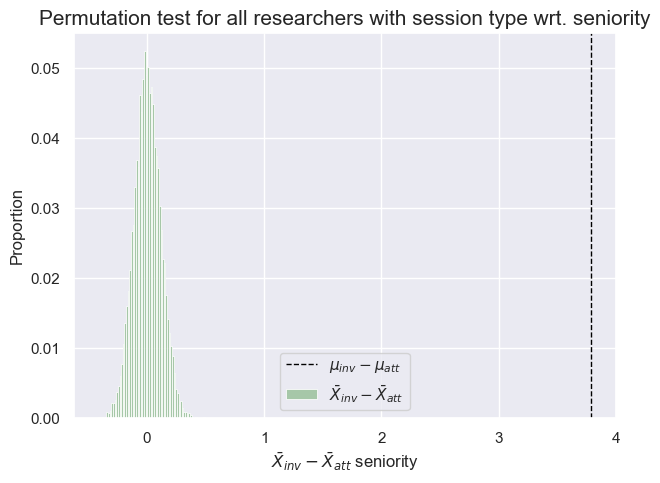

In [23]:
sns.histplot(data = permutation_sessType, x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = delta_sessionType['Seniority_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ seniority', fontsize=12)
plt.title("Permutation test for all researchers with session type wrt. seniority", fontsize = 15) 
plt.savefig("Figures/permutationTest_senioritySessType", bbox_inches='tight')
plt.show()

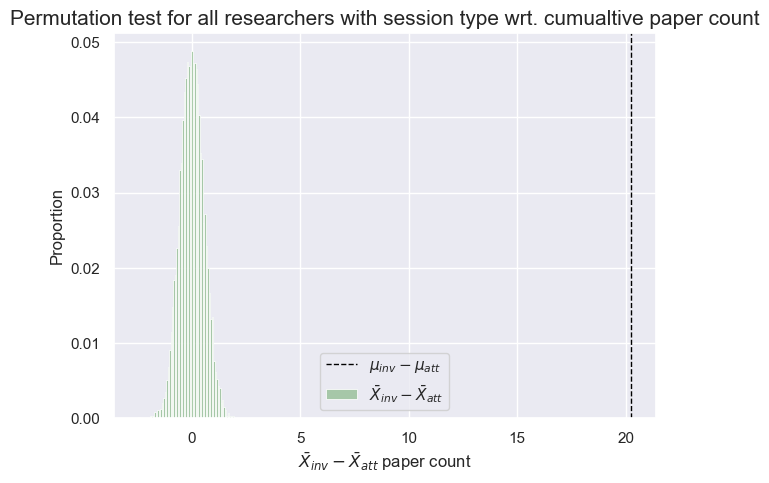

In [24]:
sns.histplot(data = permutation_sessType, x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = delta_sessionType['CumulativePaperCount_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ paper count', fontsize=12)
plt.title("Permutation test for all researchers with session type wrt. cumualtive paper count", fontsize = 15) 
plt.savefig("Figures/permutationTest_cumPaperCountSessType", bbox_inches='tight')
plt.show()

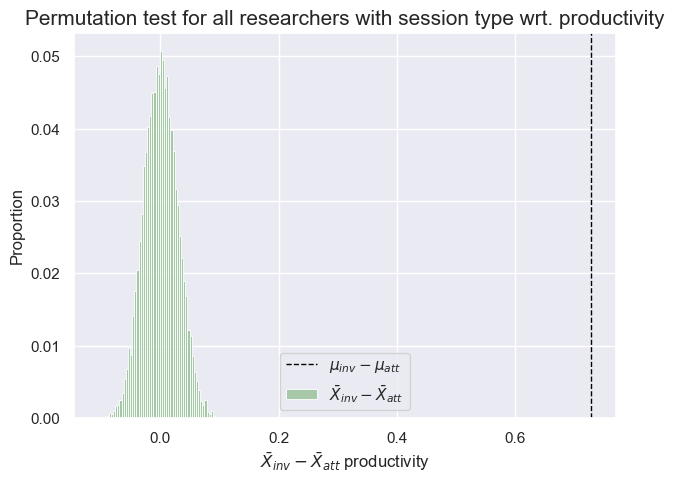

In [25]:
sns.histplot(data = permutation_sessType, x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = delta_sessionType['Productivity_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ productivity', fontsize=12)
plt.title("Permutation test for all researchers with session type wrt. productivity", fontsize = 15) 
plt.savefig("Figures/permutationTest_productivitySessType", bbox_inches='tight')
plt.show()

### Males

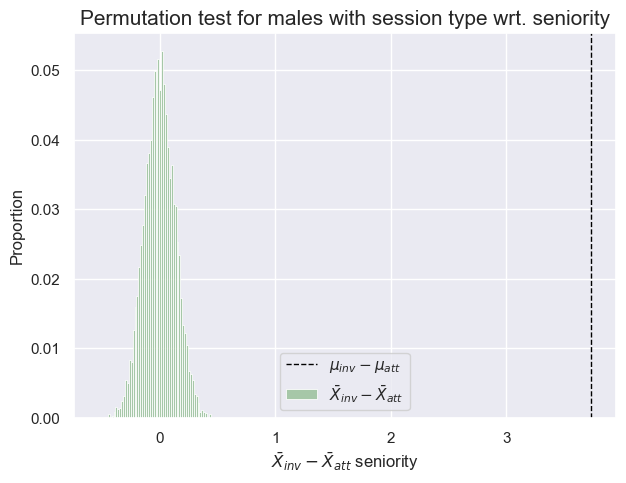

In [26]:
sns.histplot(data = permutation_M , x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaM['Seniority_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ seniority', fontsize=12)
plt.title("Permutation test for males with session type wrt. seniority", fontsize = 15) 
plt.savefig("Figures/permutationTest_seniorityMales", bbox_inches='tight')
plt.show()

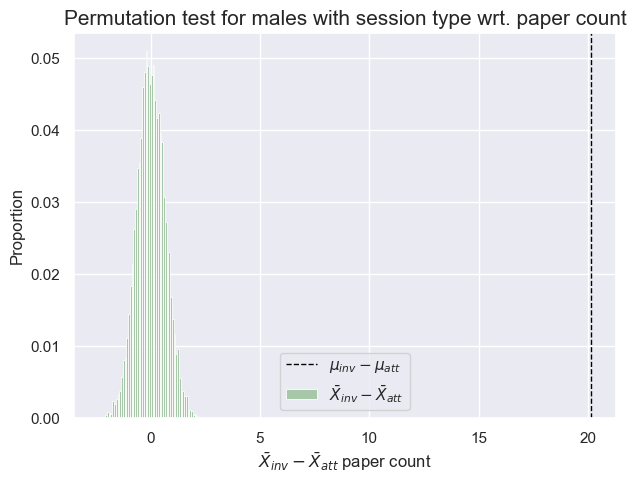

In [27]:
sns.histplot(data = permutation_M , x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaM['CumulativePaperCount_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ paper count', fontsize=12)
plt.title("Permutation test for males with session type wrt. paper count", fontsize = 15) 
plt.savefig("Figures/permutationTest_paperCountMales", bbox_inches='tight')
plt.show()

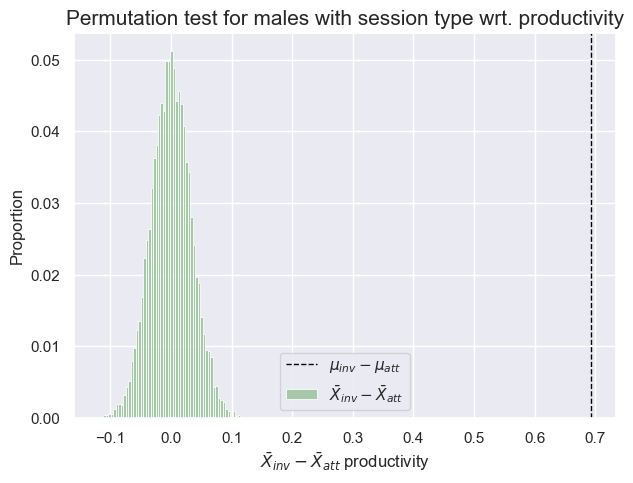

In [28]:
sns.histplot(data = permutation_M , x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaM['Productivity_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ productivity', fontsize=12)
plt.title("Permutation test for males with session type wrt. productivity", fontsize = 15) 
plt.savefig("Figures/permutationTest_productivityMales", bbox_inches='tight')
plt.show()

### Females

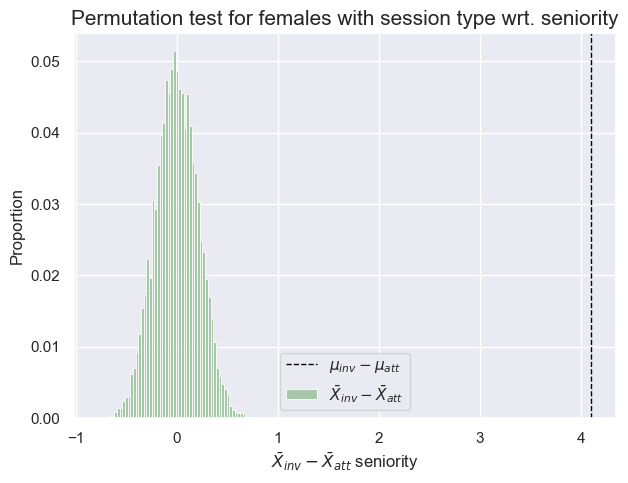

In [29]:
sns.histplot(data = permutation_F , x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaF['Seniority_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ seniority', fontsize=12)
plt.title("Permutation test for females with session type wrt. seniority", fontsize = 15) 
plt.savefig("Figures/permutationTest_seniorityFemales", bbox_inches='tight')
plt.show()

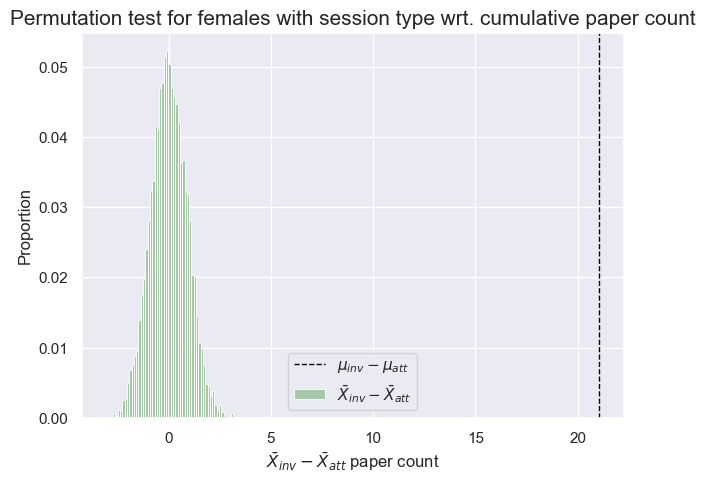

In [30]:
sns.histplot(data = permutation_F , x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaF['CumulativePaperCount_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ paper count', fontsize=12)
plt.title("Permutation test for females with session type wrt. cumulative paper count", fontsize = 15) 
plt.savefig("Figures/permutationTest_cumPaperCountFemales", bbox_inches='tight')
plt.show()

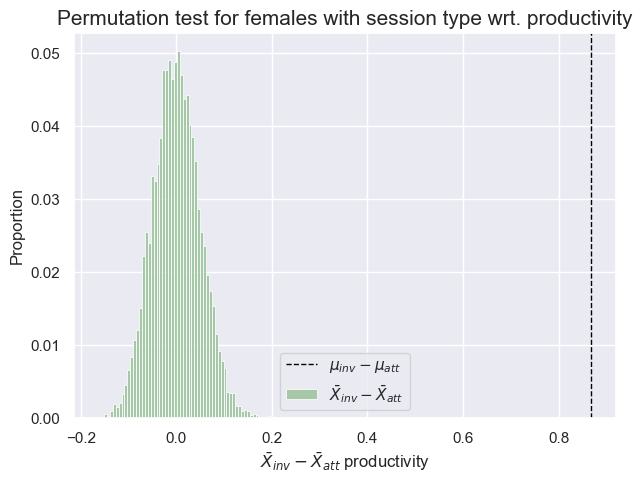

In [31]:
sns.histplot(data = permutation_F , x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = '$\\bar{X}_{inv} - \\bar{X}_{att}$')
plt.axvline(x = deltaF['Productivity_meanDiff'], color = 'black', label = '$\mu_{inv} - \mu_{att}$', linewidth = 1).set_linestyle("--")
plt.legend()
plt.xlabel('$\\bar{X}_{inv} - \\bar{X}_{att}$ productivity', fontsize=12)
plt.title("Permutation test for females with session type wrt. productivity", fontsize = 15) 
plt.savefig("Figures/permutationTest_productivityFemales", bbox_inches='tight')
plt.show()

There are significant differences between invited speakers and attendees, with invited speakers having higher seniority, having more published articles at the time of the conference and being more productive. This indicates, that invited speakers are invited based on their experience and work they publish. 

## Evolution of P-values

In [39]:
#permutate gender
delta_yearlyPerm_inv, yearlyPermutation_dict_inv = yearlyPermutationTest(invited, 'Gender', ['Female', 'Male'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
delta_yearlyPerm_att, yearlyPermutation_dict_att = yearlyPermutationTest(attendees, 'Gender', ['Female', 'Male'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [41]:
#permutate session type
delta_yearlyPermSessType_all, yearlyPermutation_dict_sessTypeAll = yearlyPermutationTest(researchers, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
delta_yearlyPermSessType_M, yearlyPermutation_dict_sessType_M = yearlyPermutationTest(researchers, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
delta_yearlyPermSessType_F, yearlyPermutation_dict_sessType_F = yearlyPermutationTest(researchers, 'SessionType', ['invited', 'attendee'], ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [42]:
#convert yearly permutation dicts to dfs
yearlyPermutation_df_inv = pd.DataFrame(yearlyPermutation_dict_inv).T.explode(['Seniority', 'CumulativePaperCount', 'Productivity']).reset_index().rename(columns={'index': 'Year'})
yearlyPermutation_df_att = pd.DataFrame(yearlyPermutation_dict_att).T.explode(['Seniority', 'CumulativePaperCount', 'Productivity']).reset_index().rename(columns={'index': 'Year'})

yearlyPermutation_df_sessTypeAll = pd.DataFrame(yearlyPermutation_dict_sessTypeAll).T.explode(['Seniority', 'CumulativePaperCount', 'Productivity']).reset_index().rename(columns={'index': 'Year'})
yearlyPermutation_df_sessType_M = pd.DataFrame(yearlyPermutation_dict_sessType_M).T.explode(['Seniority', 'CumulativePaperCount', 'Productivity']).reset_index().rename(columns={'index': 'Year'})
yearlyPermutation_df_sessType_F = pd.DataFrame(yearlyPermutation_dict_sessType_F).T.explode(['Seniority', 'CumulativePaperCount', 'Productivity']).reset_index().rename(columns={'index': 'Year'})

In [ ]:
yearlyPermutation_df_inv, yearlyPermutation_df_att, yearlyPermutation_df_sessTypeAll, yearlyPermutation_df_sessType_M, 

In [43]:
#calculate P-value per year
yearlyPvalue_inv_dict = yearlyP_value(yearlyPermutation_df_inv, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_yearlyPerm_inv)
yearlyPvalue_att_dict = yearlyP_value(yearlyPermutation_df_att, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_yearlyPerm_att)

yearlyPvalue_sessType_all_dict = yearlyP_value(yearlyPermutation_df_sessTypeAll, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_yearlyPermSessType_all)
yearlyPvalue_sessType_M_dict = yearlyP_value(yearlyPermutation_df_sessType_M, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_yearlyPermSessType_M)
yearlyPvalue_sessType_F_dict = yearlyP_value(yearlyPermutation_df_sessType_F, ['Seniority', 'CumulativePaperCount', 'Productivity'], delta_yearlyPermSessType_F)

In [44]:
#create df with p-values
yearlyP_value_inv = pd.DataFrame(yearlyPvalue_inv_dict).T.reset_index().rename(columns={'index': 'Year'})
yearlyP_value_att = pd.DataFrame(yearlyPvalue_att_dict).T.reset_index().rename(columns={'index': 'Year'})

yearlyP_value_sessType = pd.DataFrame(yearlyPvalue_sessType_all_dict).T.reset_index().rename(columns={'index': 'Year'})
yearlyP_value_M = pd.DataFrame(yearlyPvalue_sessType_M_dict).T.reset_index().rename(columns={'index': 'Year'})
yearlyP_value_F = pd.DataFrame(yearlyPvalue_sessType_F_dict).T.reset_index().rename(columns={'index': 'Year'})

In [45]:
#get lineplot to show int as in data and not 
years = invited.Year.unique().tolist()

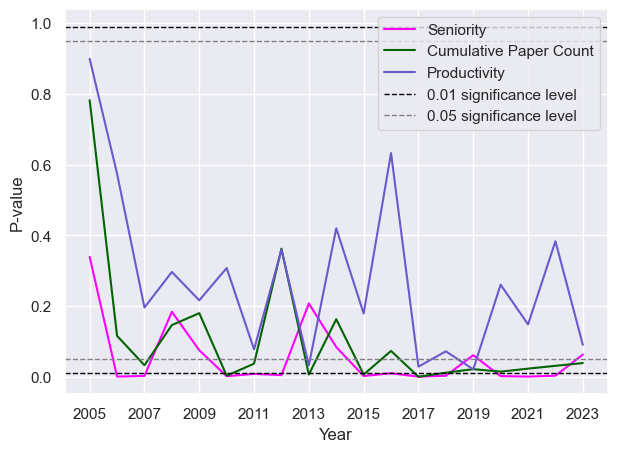

In [68]:
sns.lineplot(data = yearlyP_value_inv, x = 'Year', y = 'Seniority', color = 'magenta', label = 'Seniority')
sns.lineplot(data = yearlyP_value_inv, x = 'Year', y = 'CumulativePaperCount', color = 'darkgreen', label = 'Cumulative Paper Count')
sns.lineplot(data = yearlyP_value_inv, x = 'Year', y = 'Productivity', color = 'slateblue', label = 'Productivity')
plt.axhline(y=0.01, color = 'black', linewidth=1, label = '0.01 significance level').set_linestyle("--")
plt.axhline(y=0.99, color = 'black', linewidth=1).set_linestyle("--")
plt.axhline(y=0.05, color = 'grey', linewidth=1, label = '0.05 significance level').set_linestyle("--")
plt.axhline(y=0.95, color = 'grey', linewidth=1).set_linestyle("--")
plt.legend(loc = 'upper right')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel('P-value', fontsize=12)
#plt.title("Evolution of p-values for invited speakers", fontsize = 15)
plt.savefig("Figures/pValues_evolution", bbox_inches='tight')
plt.show()

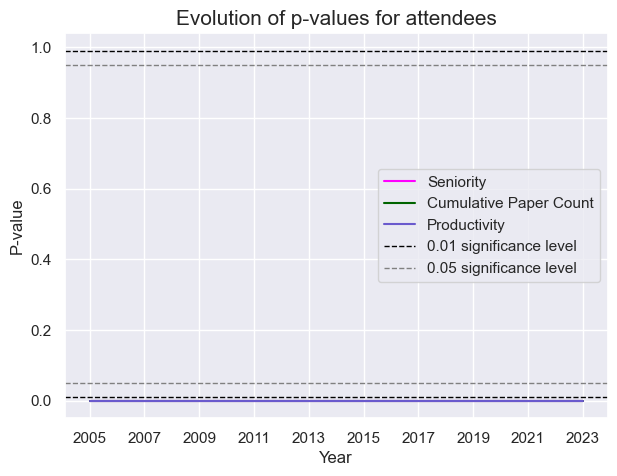

In [66]:
sns.lineplot(data = yearlyP_value_att, x = 'Year', y = 'Seniority', color = 'magenta', label = 'Seniority')
sns.lineplot(data = yearlyP_value_att, x = 'Year', y = 'CumulativePaperCount', color = 'darkgreen', label = 'Cumulative Paper Count')
sns.lineplot(data = yearlyP_value_att, x = 'Year', y = 'Productivity', color = 'slateblue', label = 'Productivity')
plt.axhline(y=0.01, color = 'black', linewidth=1, label = '0.01 significance level').set_linestyle("--")
plt.axhline(y=0.99, color = 'black', linewidth=1).set_linestyle("--")
plt.axhline(y=0.05, color = 'grey', linewidth=1, label = '0.05 significance level').set_linestyle("--")
plt.axhline(y=0.95, color = 'grey', linewidth=1).set_linestyle("--")
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel('P-value', fontsize=12)
plt.title("Evolution of p-values for attendees", fontsize = 15)
plt.savefig("Figures/pValues_evolution_att", bbox_inches='tight')
plt.show()

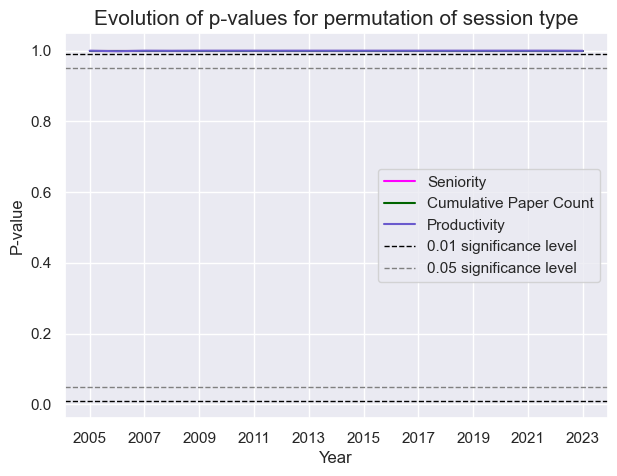

In [67]:
sns.lineplot(data = yearlyP_value_sessType, x = 'Year', y = 'Seniority', color = 'magenta', label = 'Seniority')
sns.lineplot(data = yearlyP_value_sessType, x = 'Year', y = 'CumulativePaperCount', color = 'darkgreen', label = 'Cumulative Paper Count')
sns.lineplot(data = yearlyP_value_sessType, x = 'Year', y = 'Productivity', color = 'slateblue', label = 'Productivity')
plt.axhline(y=0.01, color = 'black', linewidth=1, label = '0.01 significance level').set_linestyle("--")
plt.axhline(y=0.99, color = 'black', linewidth=1).set_linestyle("--")
plt.axhline(y=0.05, color = 'grey', linewidth=1, label = '0.05 significance level').set_linestyle("--")
plt.axhline(y=0.95, color = 'grey', linewidth=1).set_linestyle("--")
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel('P-value', fontsize=12)
plt.title("Evolution of p-values for permutation of session type", fontsize = 15)
plt.savefig("Figures/pValues_evolution_sessionTypeAll", bbox_inches='tight')
plt.show()

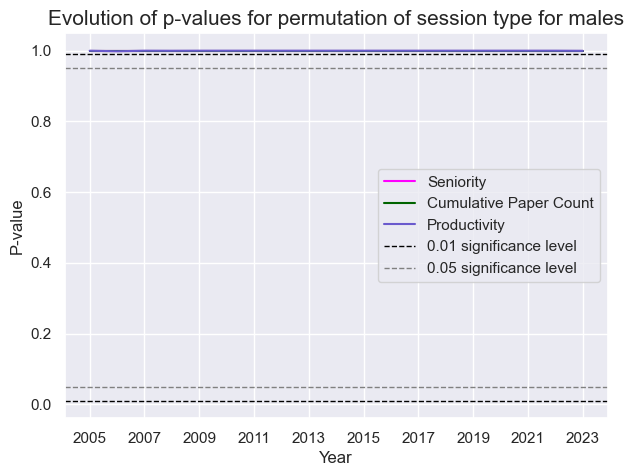

In [69]:
sns.lineplot(data = yearlyP_value_M, x = 'Year', y = 'Seniority', color = 'magenta', label = 'Seniority')
sns.lineplot(data = yearlyP_value_M, x = 'Year', y = 'CumulativePaperCount', color = 'darkgreen', label = 'Cumulative Paper Count')
sns.lineplot(data = yearlyP_value_M, x = 'Year', y = 'Productivity', color = 'slateblue', label = 'Productivity')
plt.axhline(y=0.01, color = 'black', linewidth=1, label = '0.01 significance level').set_linestyle("--")
plt.axhline(y=0.99, color = 'black', linewidth=1).set_linestyle("--")
plt.axhline(y=0.05, color = 'grey', linewidth=1, label = '0.05 significance level').set_linestyle("--")
plt.axhline(y=0.95, color = 'grey', linewidth=1).set_linestyle("--")
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel('P-value', fontsize=12)
plt.title("Evolution of p-values for permutation of session type for males", fontsize = 15)
plt.savefig("Figures/pValues_evolution_sessionTypeMales", bbox_inches='tight')
plt.show()

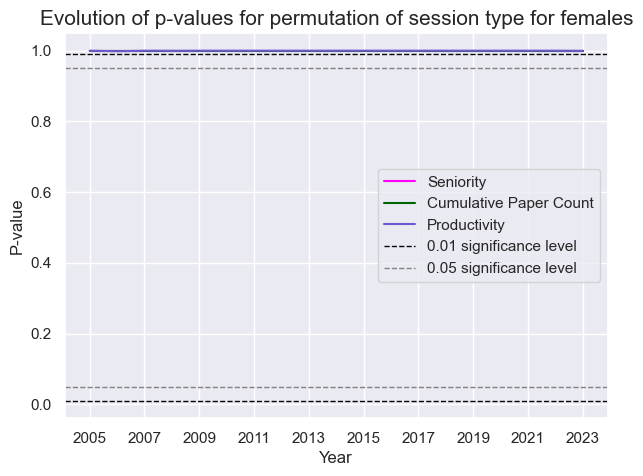

In [71]:
sns.lineplot(data = yearlyP_value_F, x = 'Year', y = 'Seniority', color = 'magenta', label = 'Seniority')
sns.lineplot(data = yearlyP_value_F, x = 'Year', y = 'CumulativePaperCount', color = 'darkgreen', label = 'Cumulative Paper Count')
sns.lineplot(data = yearlyP_value_F, x = 'Year', y = 'Productivity', color = 'slateblue', label = 'Productivity')
plt.axhline(y=0.01, color = 'black', linewidth=1, label = '0.01 significance level').set_linestyle("--")
plt.axhline(y=0.99, color = 'black', linewidth=1).set_linestyle("--")
plt.axhline(y=0.05, color = 'grey', linewidth=1, label = '0.05 significance level').set_linestyle("--")
plt.axhline(y=0.95, color = 'grey', linewidth=1).set_linestyle("--")
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel('P-value', fontsize=12)
plt.title("Evolution of p-values for permutation of session type for females", fontsize = 15)
plt.savefig("Figures/pValues_evolution_sessionTypeFemales", bbox_inches='tight')
plt.show()

The permutation test shows that there is significant difference between males and females regarding seniority and cumulative paper count for invited speakers. Males have significant higher seniority and publish significant more papers than females. The productivity is borderline regarding significance. According to article about P-values, it does not really makes sense to conclude anything about productivity. This especially makes sense, when we did not try every possible permutation.

For attendees, the differences in seniority, cumulative paper count and productivity are significant towards males having higher values. 

When looking at the evolution of P-values, we can see that seniority, cumulative paper count and productivity are all significant from 2005-2023 for attendees. This means(based on this data) that males do publish more, are more productive and do have more years in the field. However, when looking at the invited speakers, the P-values differ a lot. What this probably means, is that invited speakers are not invited based on these features. And since there are few invited speakers compared to attendees, it seems arbitrary if the features are significant or not. What this could indicate is that invited speakers are selected based on other features, and they might even be invited based on their results. However, we have no way of knowing this, especially since we could not get citations at the time of the conference. Maybe there is some other way to measure quality of research. 

Seniority: 
invited: random forskel mellem -1 og 1. True: 3
attendees: random forskel mellem -0.25 og 0.25. True: 3.5
        
Cumulative paper count: 
invited: random forskel mellem -5 og 5. True: 10
attendees: random forskel mellem -1 og 1. True: 12
        
Productivity: 
invited: random forskel mellem -0.3 og 0.3. True: 0.2
attendees: random forskel mellem -0.025 og 0.025. True: 0.4
        
        
lidt mærkeligt hvor normalfordelt permutations er. 

## Violin plots

In [ ]:
sns.violinplot(data=df, x="class", y="age", hue="alive", split=True, inner="quart")

## Difference between male and female

In [72]:
diffDict_inv = getDiff(invited, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'])
diffDict_att = getDiff(attendees, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'])

In [73]:
invDiff_df = pd.DataFrame.from_dict(diffDict_inv, orient='index') #convert dict to df
attDiff_df = pd.DataFrame.from_dict(diffDict_att, orient='index') #convert dict to df

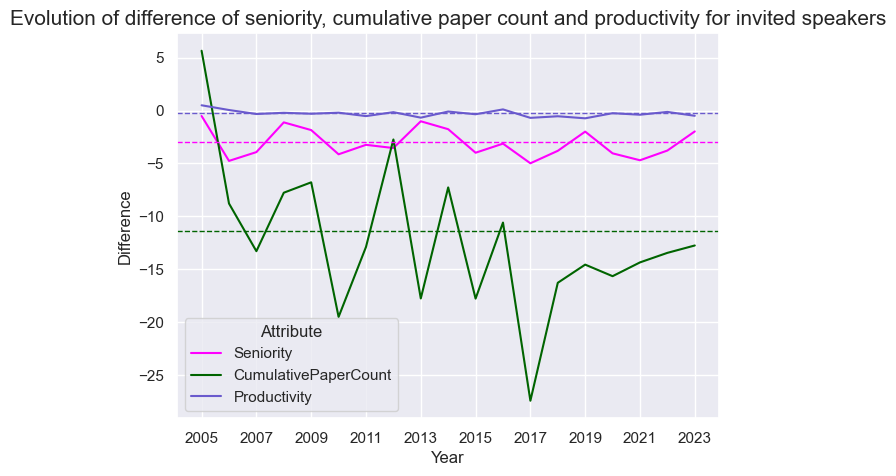

In [76]:
sns.lineplot(data = invDiff_df, x = 'Year', y = 'Difference', hue = 'Attribute', palette = ['magenta', 'darkgreen', 'slateblue'])
plt.axhline(y = delta_inv['Seniority_meanDiff'], color = 'magenta', linewidth = 1, label = 'Seniority mean difference').set_linestyle('--')
plt.axhline(y = delta_inv['CumulativePaperCount_meanDiff'], color = 'darkgreen', linewidth = 1, label = 'Cumulative paper count mean difference').set_linestyle('--')
plt.axhline(y = delta_inv['Productivity_meanDiff'], color = 'slateblue', linewidth = 1, label = 'Productivity mean difference').set_linestyle('--')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.title("Evolution of difference of seniority, cumulative paper count and productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/attributeValues_evolution", bbox_inches='tight')
plt.show()

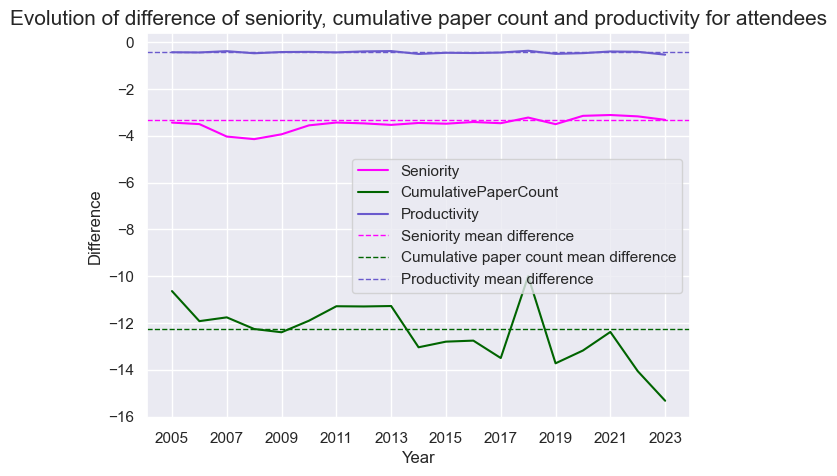

In [77]:
sns.lineplot(data = attDiff_df, x = 'Year', y = 'Difference', hue = 'Attribute', palette = ['magenta', 'darkgreen', 'slateblue'])
plt.axhline(y = delta_att['Seniority_meanDiff'], color = 'magenta', linewidth = 1, label = 'Seniority mean difference').set_linestyle('--')
plt.axhline(y = delta_att['CumulativePaperCount_meanDiff'], color = 'darkgreen', linewidth = 1, label = 'Cumulative paper count mean difference').set_linestyle('--')
plt.axhline(y = delta_att['Productivity_meanDiff'], color = 'slateblue', linewidth = 1, label = 'Productivity mean difference').set_linestyle('--')
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.title("Evolution of difference of seniority, cumulative paper count and productivity for attendees", fontsize = 15)
plt.savefig("Figures/attributeValues_evolution_att", bbox_inches='tight')
plt.show()

#the differences are pretty constant, why the result seen in permutation test also is seen in yearly p-values

In [78]:
#select productivity from diff df for invited speakers
productivityDiffInv = invDiff_df[invDiff_df.Attribute == 'Productivity']

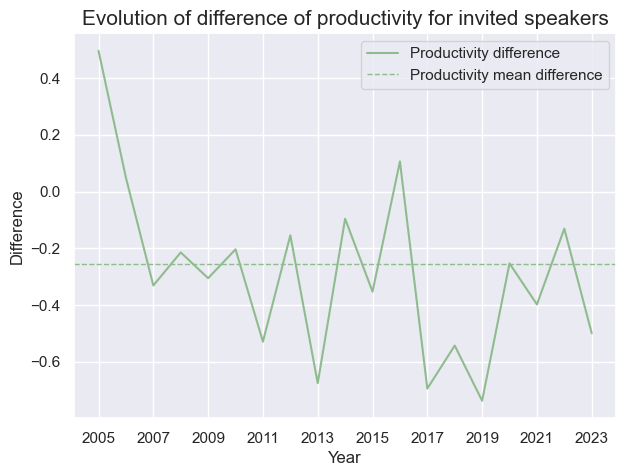

In [79]:
sns.lineplot(data = productivityDiffInv, x = 'Year', y = 'Difference', color = 'darkseagreen', label = 'Productivity difference')
plt.axhline(y = delta_inv['Productivity_meanDiff'], color = 'darkseagreen', linewidth = 1, label = 'Productivity mean difference').set_linestyle('--')
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.title("Evolution of difference of productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/productivityEvolution", bbox_inches='tight')
plt.show()

In [80]:
meanInvited = invited.groupby(['Year', 'Gender']).mean(numeric_only = True).reset_index()
genderMean = invited.groupby('Gender').mean(numeric_only = True)
genderMean.Seniority['Female']

16.553875236294896

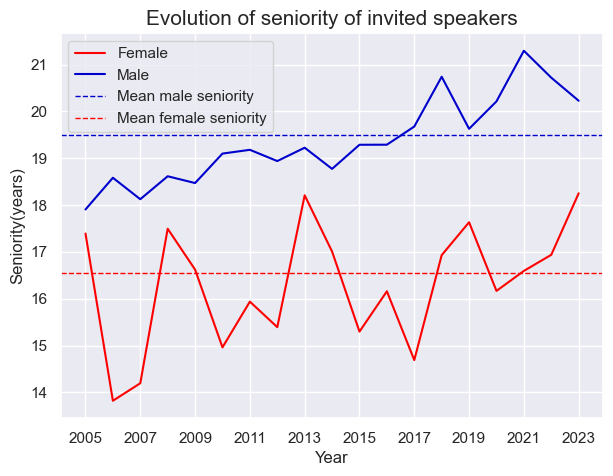

In [81]:
sns.lineplot(data = meanInvited, x = 'Year', y = 'Seniority', hue = 'Gender', palette=['red', 'mediumblue'])
plt.axhline(y = genderMean.Seniority['Male'], color = 'mediumblue', linewidth = 1, label = 'Mean male seniority').set_linestyle('--')
plt.axhline(y = genderMean.Seniority['Female'], color = 'red', linewidth = 1, label = 'Mean female seniority').set_linestyle('--')
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Seniority(years)", fontsize=12)
plt.title("Evolution of seniority of invited speakers", fontsize = 15)
plt.savefig("Figures/seniorityInvited_evolution.png", bbox_inches='tight')
plt.show()

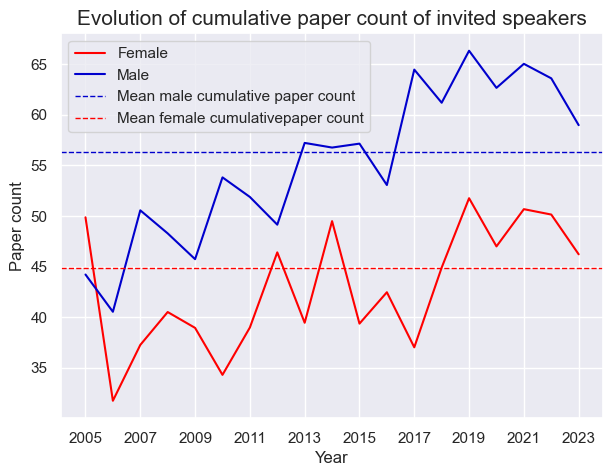

In [82]:
sns.lineplot(data = meanInvited, x = 'Year', y = 'CumulativePaperCount', hue = 'Gender', palette=['red', 'mediumblue'])
plt.axhline(y = genderMean.CumulativePaperCount['Male'], color = 'mediumblue', linewidth = 1, label = 'Mean male cumulative paper count').set_linestyle('--')
plt.axhline(y = genderMean.CumulativePaperCount['Female'], color = 'red', linewidth = 1, label = 'Mean female cumulativepaper count').set_linestyle('--')
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Paper count", fontsize=12)
plt.title("Evolution of cumulative paper count of invited speakers", fontsize = 15)
plt.savefig("Figures/cumulativePaperCountInvited_evolution.png", bbox_inches='tight')
plt.show()

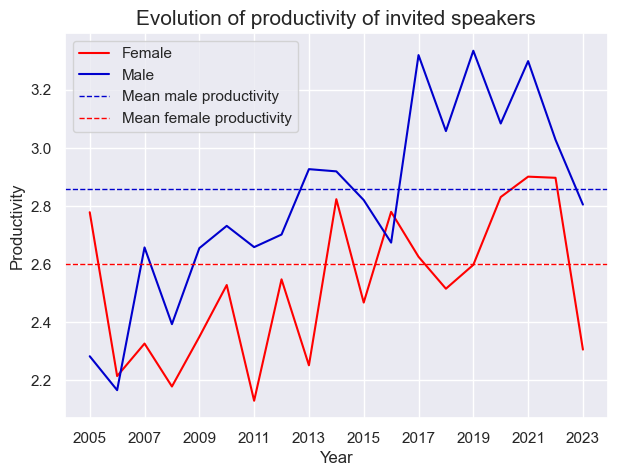

In [83]:
sns.lineplot(data = meanInvited, x = 'Year', y = 'Productivity', hue = 'Gender', palette=['red', 'mediumblue'])
plt.axhline(y = genderMean.Productivity['Male'], color = 'mediumblue', linewidth = 1, label = 'Mean male productivity').set_linestyle('--')
plt.axhline(y = genderMean.Productivity['Female'], color = 'red', linewidth = 1, label = 'Mean female productivity').set_linestyle('--')
plt.legend()
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Productivity", fontsize=12)
plt.title("Evolution of productivity of invited speakers", fontsize = 15)
plt.savefig("Figures/productivityInvited_evolution.png", bbox_inches='tight')
plt.show()